# Extended basic model
This notebook has the same ideas as ```basic_model.ipynb```, but I add some improvements:
1. Increase the size of the dataset. Now it's 11017 images with different levels of players (professional dan players, amateurs and ordinary dan players).
2. Split our dataset to train, validation and test sets.
3. Transform images from RGB to Grayscale, for reduce the complexity of our model.
4. Increase number of epochs.

GPU which used for training ur model:

In [109]:
!nvidia-smi --query-gpu=gpu_name,memory.total,memory.free --format=csv

name, memory.total [MiB], memory.free [MiB]
Tesla P100-PCIE-16GB, 16280 MiB, 1279 MiB


## Libraries

In [112]:
from collections import Counter 
from prettytable import PrettyTable
from torch import nn
from torchvision import transforms, datasets, utils, models
from tqdm import tqdm
import torch

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 

## Downloading dataset
Downloading our dataset from Google Drive

In [3]:
!pip install gdown > /dev/null
!gdown --id 1iakpnu-5P0SxuYyFPtVi7PlU1bj9ziVd

Downloading...
From: https://drive.google.com/uc?id=1iakpnu-5P0SxuYyFPtVi7PlU1bj9ziVd
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 1.48G/1.48G [00:04<00:00, 326MB/s]


In [4]:
!unzip dataset.zip > /dev/null

## Set some basic parameters and constants

In [5]:
DATASET_DIR = "dataset"
TRAIN_PERCENT = 0.75
VALID_PERCENT = 0.15
TEST_PERCENT = 0.1

SEED = 42
BATCH_SIZE = 32
EPOCHS = 40

np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams["figure.figsize"] = [15, 8]
plt.rcParams["font.size"] = 20

## Dataset preparation

In [6]:
data_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
dataset = datasets.ImageFolder(root=DATASET_DIR,
                                           transform=data_transform)

Transform our dataset from RGB 3-channel images to grayscale 1-channel images

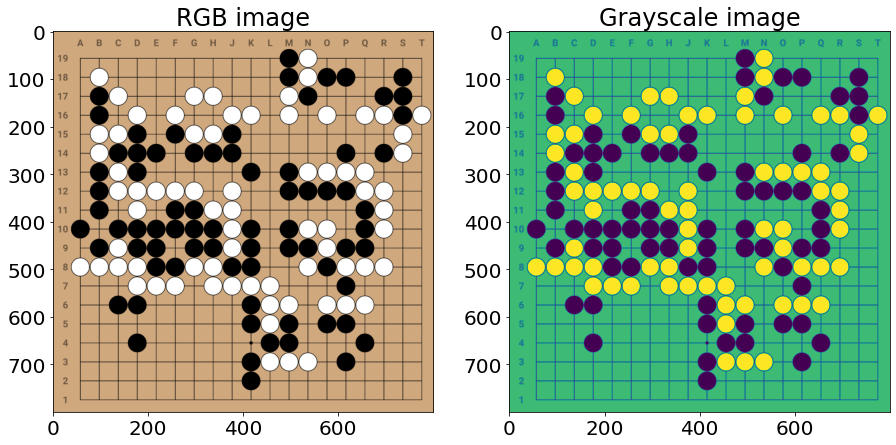

In [139]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(plt.imread(dataset.imgs[0][0]))
ax[0].set_title("RGB image")
ax[1].imshow(dataset[0][0].permute(1, 2, 0))
ax[1].set_title("Grayscale image");

## Split dataset into train, validation and test sets

In [7]:
DATASET_LENGTH = len(dataset)
TRAIN_LENGTH = int(DATASET_LENGTH * TRAIN_PERCENT)
VALID_LENGTH = int(DATASET_LENGTH * VALID_PERCENT)
TEST_LENGTH = DATASET_LENGTH - TRAIN_LENGTH - VALID_LENGTH
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                        [TRAIN_LENGTH, VALID_LENGTH, TEST_LENGTH], 
                                        generator=torch.Generator().manual_seed(SEED))

In [8]:
datasets_length_table = PrettyTable()
datasets_length_table.field_names = ["Dataset name", "Length of dataset"]
datasets_length_table.add_row(["Train dataset", TRAIN_LENGTH])
datasets_length_table.add_row(["Validation dataset", VALID_LENGTH])
datasets_length_table.add_row(["Test dataset", TEST_LENGTH])
datasets_length_table.add_row(["All dataset", DATASET_LENGTH])
print(datasets_length_table)

+--------------------+-------------------+
|    Dataset name    | Length of dataset |
+--------------------+-------------------+
|   Train dataset    |        8262       |
| Validation dataset |        1652       |
|    Test dataset    |        1103       |
|    All dataset     |       11017       |
+--------------------+-------------------+


In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE, shuffle=True)

In [10]:
def distribution_plot(loader: torch.utils.data.dataloader.DataLoader, dataset_mode:str)->None:
    
    targets = []

    for _, target in loader:
        targets.extend(target.tolist())
    
    indexes = {
        "train": 0, 
        "valid": 1,
        "test": 2
    }
    
    index = indexes[dataset_mode]
    
    graph = sns.barplot(data=pd.DataFrame(data = np.array([[*Counter(targets).values()]]), 
                                      columns=loader.dataset.dataset.classes), ax = ax[index])
    
    ax[index].set_title(f"Distribution of classes"
                        "\n"
                        f"in {dataset_mode.title()} Dataset")
    ax[index].set_ylabel("Count")
    for p in graph.patches:
        graph.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                            ha='center', va='center', fontsize=20, xytext=(0, 9),
                            textcoords='offset points',fontweight='light', alpha=0.95) 

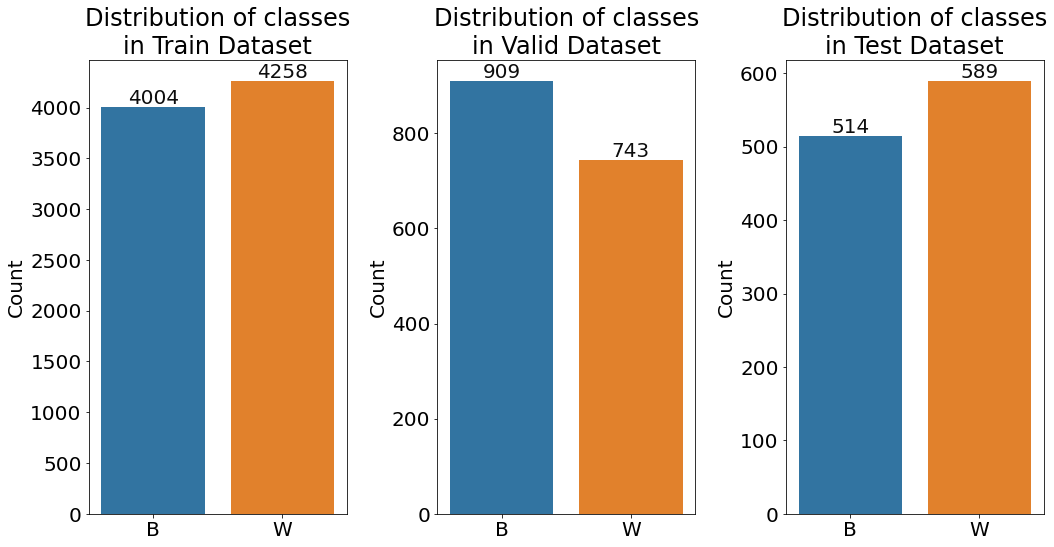

In [11]:
fig, ax = plt.subplots(1,3)
distribution_plot(train_loader, "train")
distribution_plot(valid_loader, "valid")
distribution_plot(test_loader, "test")
fig.tight_layout()
fig.show()

## Visualize random images from dataset

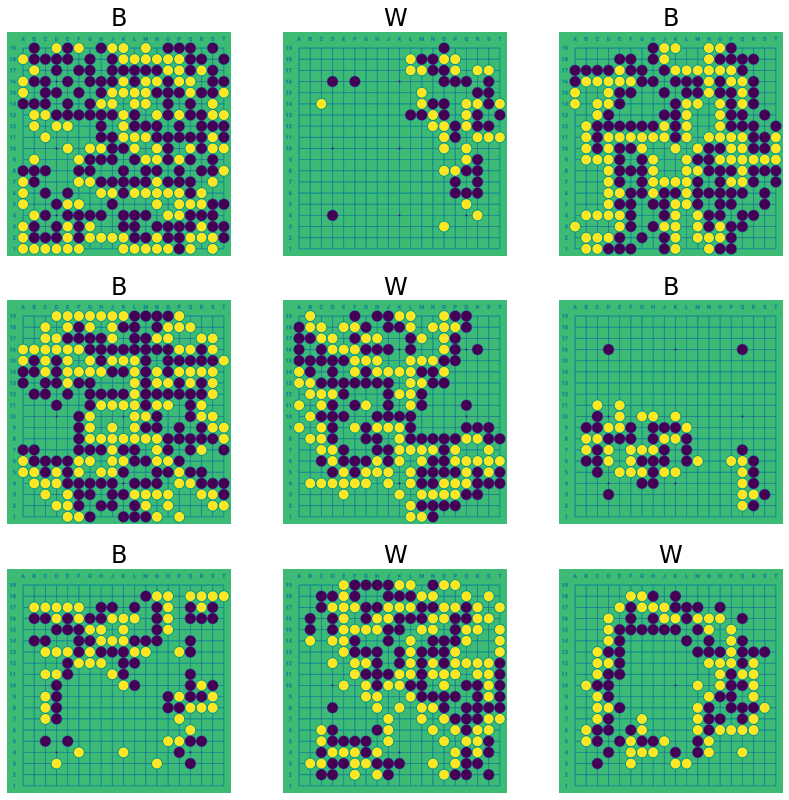

In [12]:
figure = plt.figure(figsize=(14, 14))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.show()

## Model and training cycle

In [19]:
model_resnet = models.resnet18(pretrained=False)
model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
output_features = len(train_dataset.dataset.classes)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, output_features)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
print(f"Availiable device for training: <{device}>")

model_resnet = model_resnet.to(device)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
loss = nn.CrossEntropyLoss()  

train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(1, EPOCHS + 1):
    train_loss = 0
    valid_loss = 0
    train_acc = 0
    valid_acc = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        model_resnet.train()
        for (X, y) in tepoch:
            tepoch.set_description(f"Epoch [{epoch}/{EPOCHS}] | LR [{optimizer.param_groups[0]['lr']}] | Train set")
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model_resnet(X)
            l = loss(y_hat, y)
            l.backward()
            train_loss += l.item()
            train_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
            optimizer.step()
            tepoch.set_postfix({"Train Loss": train_loss / len(train_loader), 
                                "Train Accuracy":  100. * train_acc / TRAIN_LENGTH})
    train_losses.append(train_loss/len(train_loader))
    train_accuracies.append(100. * train_acc / TRAIN_LENGTH)
        
    model_resnet.eval()
    with torch.no_grad():
        with tqdm(valid_loader, unit="batch") as tepoch:

            for (X, y) in tepoch:
                tepoch.set_description(" " * (22 + int(np.log10(epoch))) + "Validation set")
                X, y = X.to(device), y.to(device)

                y_hat = model_resnet(X)
                l = loss(y_hat, y)

                valid_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
                valid_loss += l.item()
                tepoch.set_postfix({"Validation Loss": valid_loss / len(valid_loader), 
                                "Validation Accuracy": 100. * valid_acc / VALID_LENGTH})
    valid_losses.append(valid_loss/len(valid_loader))
    valid_accuracies.append(100. * valid_acc / VALID_LENGTH)
    scheduler.step(valid_loss/len(valid_loader))
    torch.save(model_resnet.state_dict(), f"weights-epoch-{epoch}.h5")

Availiable device for training: <cuda:0>


Epoch [1/40] | LR [0.01] | Train set: 100%|██████████| 259/259 [04:08<00:00,  1.04batch/s, Train Loss=0.689, Train Accuracy=63]   
                      Validation set: 100%|██████████| 52/52 [00:30<00:00,  1.73batch/s, Validation Loss=0.6, Validation Accuracy=68.1]   
Epoch [2/40] | LR [0.01] | Train set: 100%|██████████| 259/259 [04:08<00:00,  1.04batch/s, Train Loss=0.576, Train Accuracy=70.1] 
                      Validation set: 100%|██████████| 52/52 [00:29<00:00,  1.73batch/s, Validation Loss=0.819, Validation Accuracy=58.1]
Epoch [3/40] | LR [0.01] | Train set: 100%|██████████| 259/259 [04:07<00:00,  1.05batch/s, Train Loss=0.569, Train Accuracy=70.3] 
                      Validation set: 100%|██████████| 52/52 [00:30<00:00,  1.73batch/s, Validation Loss=0.569, Validation Accuracy=73]  
Epoch [4/40] | LR [0.01] | Train set: 100%|██████████| 259/259 [04:08<00:00,  1.04batch/s, Train Loss=0.554, Train Accuracy=71.5]
                      Validation set: 100%|██████████| 52/52 [

In [20]:
def metric_plot(train_metric: list, valid_metric: list, metric_name: str) -> None:
    plt.plot(train_metric,'-o')
    plt.plot(valid_metric,'-o')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend([f'Train {metric_name}',f'Test {metric_name}'])
    plt.title(f'Model {metric_name}')
    plt.show()

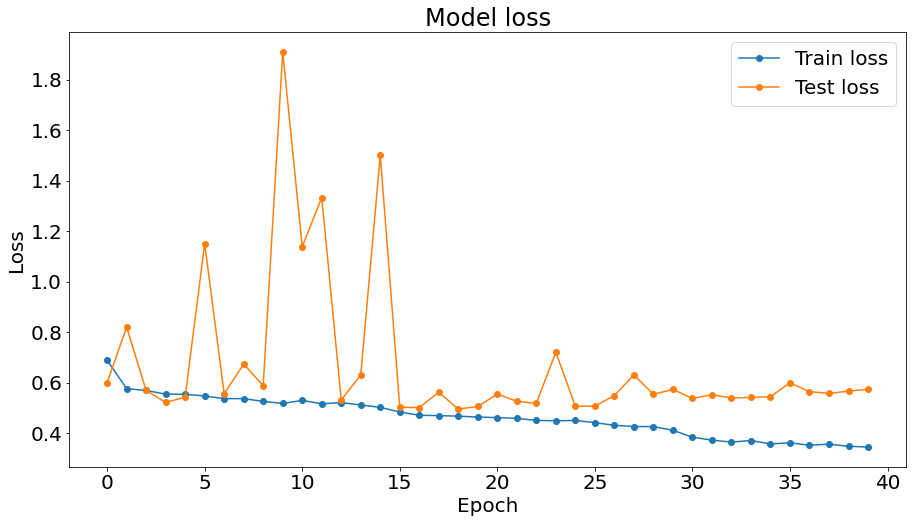

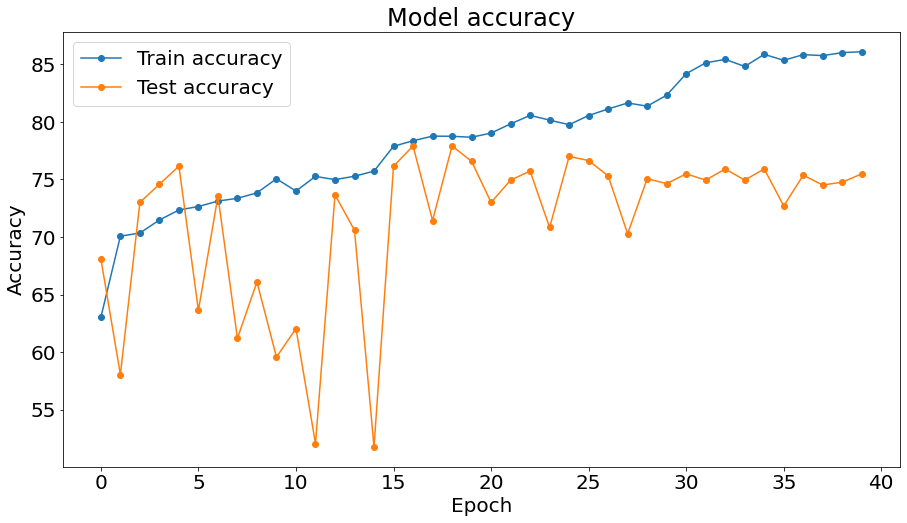

In [21]:
metric_plot(train_losses, valid_losses, "loss")
metric_plot(train_accuracies, valid_accuracies, "accuracy")

## Check our model on test dataset
To get an unbiased evaluation of our model, we need to calculate loss and accuracy on unseen data from the test dataset

In [48]:
test_acc, test_loss = 0, 0
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as tepoch:

        for (X, y) in tepoch:
            tepoch.set_description("Test set")
            X, y = X.to(device), y.to(device)

            y_hat = model_resnet(X)
            l = loss(y_hat, y)

            test_acc += torch.sum(y_hat.max(dim=1)[1] == y).item()
            test_loss += l.item()
            tepoch.set_postfix({"Test Loss": test_loss / len(test_loader), 
                            "Test Accuracy": 100. * test_acc / TEST_LENGTH})

Test set: 100%|██████████| 35/35 [00:20<00:00,  1.73batch/s, Test Loss=0.604, Test Accuracy=73.9]


## Visualize predictions of our model
The title of the image is a real label. If title with red color - our model is wrong on this image, green is right

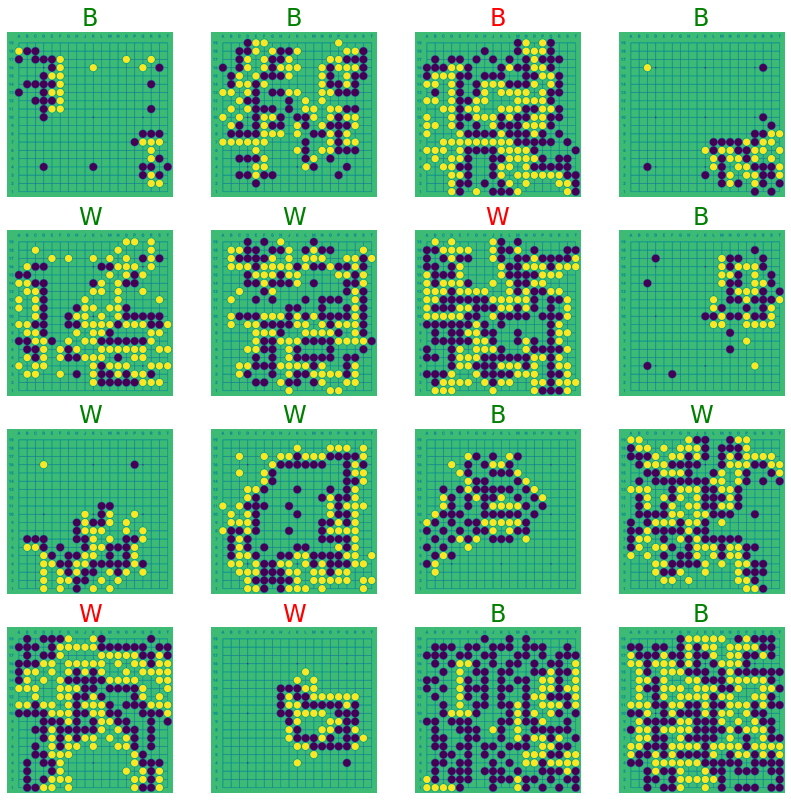

In [147]:
figure = plt.figure(figsize=(14, 14))
cols, rows = 4, 4
images, labels = next(iter(test_loader))
for i in range(1, cols * rows + 1):
    img, label = images[i], labels[i]
    predicted_label = model_resnet(img.reshape(1, 1, 800, 800).cuda())
    color = "green"
    if predicted_label.max(dim=1)[1] != label:
        color = "red"
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.dataset.classes[label], color=color)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
plt.show()